In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.feature_selection import mutual_info_classif, chi2, f_classif, RFE, SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('alzheimers_disease_data.csv')

In [2]:
# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("Dataset Info:")
df.info()
print("First 5 rows:")
df.head()

# Check for missing values
print("Missing Values:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

Dataset Shape: (2149, 35)
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2149 entries, 0 to 2148
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PatientID                  2149 non-null   int64  
 1   Age                        2149 non-null   int64  
 2   Gender                     2149 non-null   int64  
 3   Ethnicity                  2149 non-null   int64  
 4   EducationLevel             2149 non-null   int64  
 5   BMI                        2149 non-null   float64
 6   Smoking                    2149 non-null   int64  
 7   AlcoholConsumption         2149 non-null   float64
 8   PhysicalActivity           2149 non-null   float64
 9   DietQuality                2149 non-null   float64
 10  SleepQuality               2149 non-null   float64
 11  FamilyHistoryAlzheimers    2149 non-null   int64  
 12  CardiovascularDisease      2149 non-null   int64  
 13  Diabetes

In [3]:
 # 1. (EDA)

# Identify numerical and categorical columns
numerical_columns = [col for col in df.columns if df[col].nunique() > 10]
categorical_columns = df.columns.difference(numerical_columns).difference(['Diagnosis']).to_list()

print(f"Numerical columns ({len(numerical_columns)}): {numerical_columns}")
print(f"Categorical columns ({len(categorical_columns)}): {categorical_columns}")

Numerical columns (16): ['PatientID', 'Age', 'BMI', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality', 'SystolicBP', 'DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment', 'ADL']
Categorical columns (18): ['BehavioralProblems', 'CardiovascularDisease', 'Confusion', 'Depression', 'Diabetes', 'DifficultyCompletingTasks', 'Disorientation', 'DoctorInCharge', 'EducationLevel', 'Ethnicity', 'FamilyHistoryAlzheimers', 'Forgetfulness', 'Gender', 'HeadInjury', 'Hypertension', 'MemoryComplaints', 'PersonalityChanges', 'Smoking']


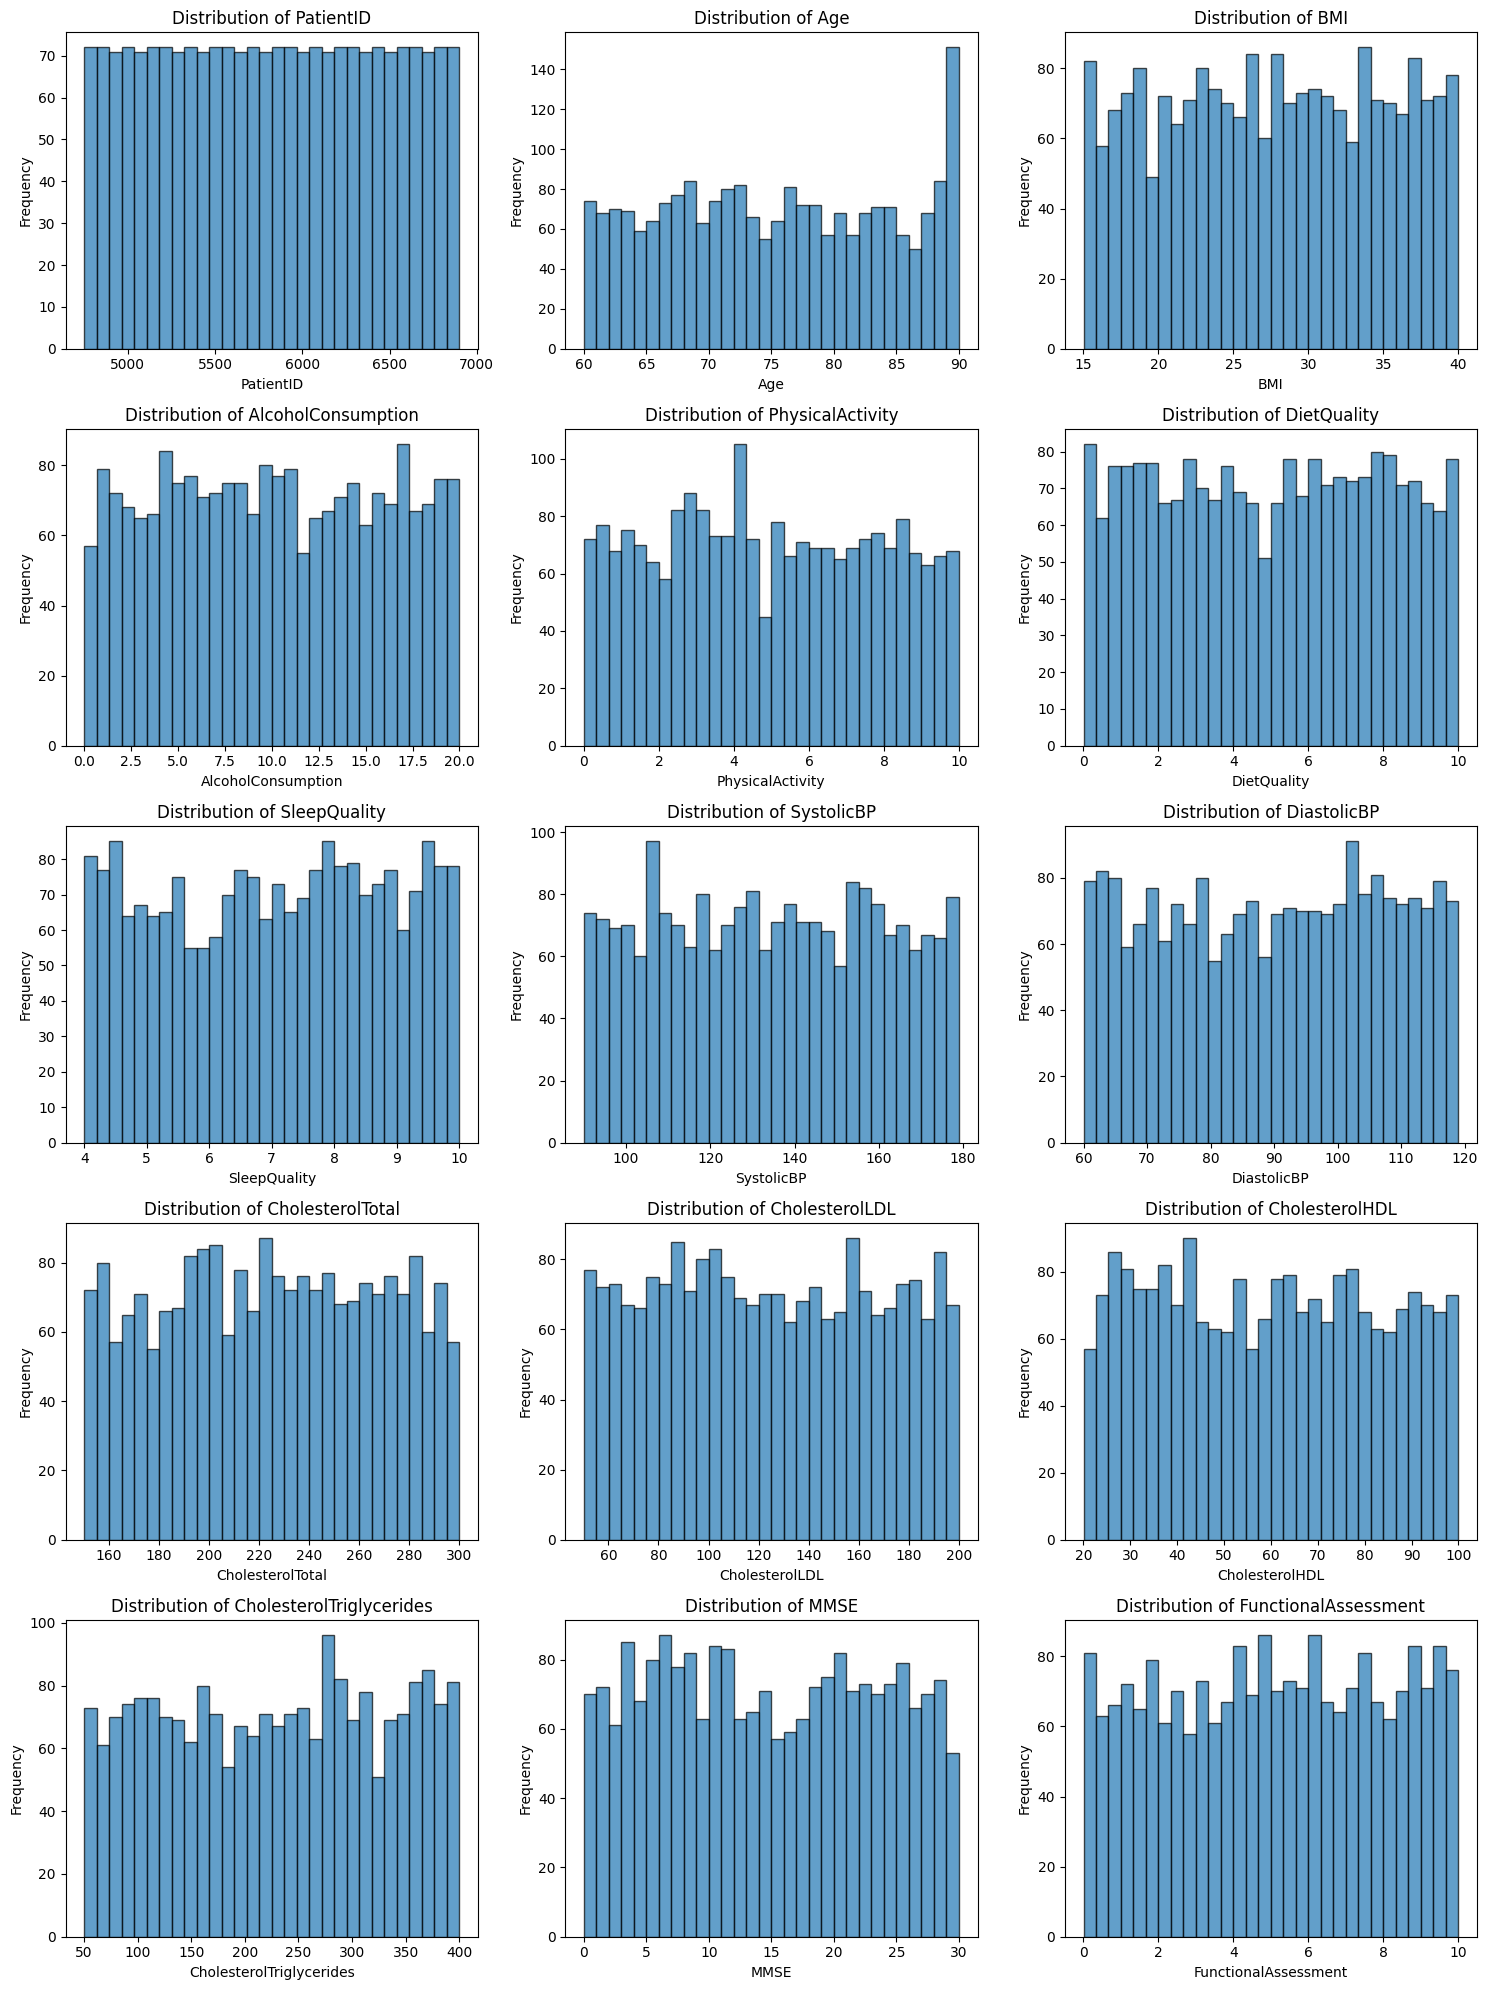

In [4]:
# Visualize distribution of numerical features
fig, axes = plt.subplots(5, 3, figsize=(15, 20))
axes = axes.ravel()

for idx, col in enumerate(numerical_columns[:15]):  # Show first 15 numerical columns
    if idx < len(axes):
        axes[idx].hist(df[col].dropna(), bins=30, edgecolor='black', alpha=0.7)
        axes[idx].set_title(f'Distribution of {col}')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


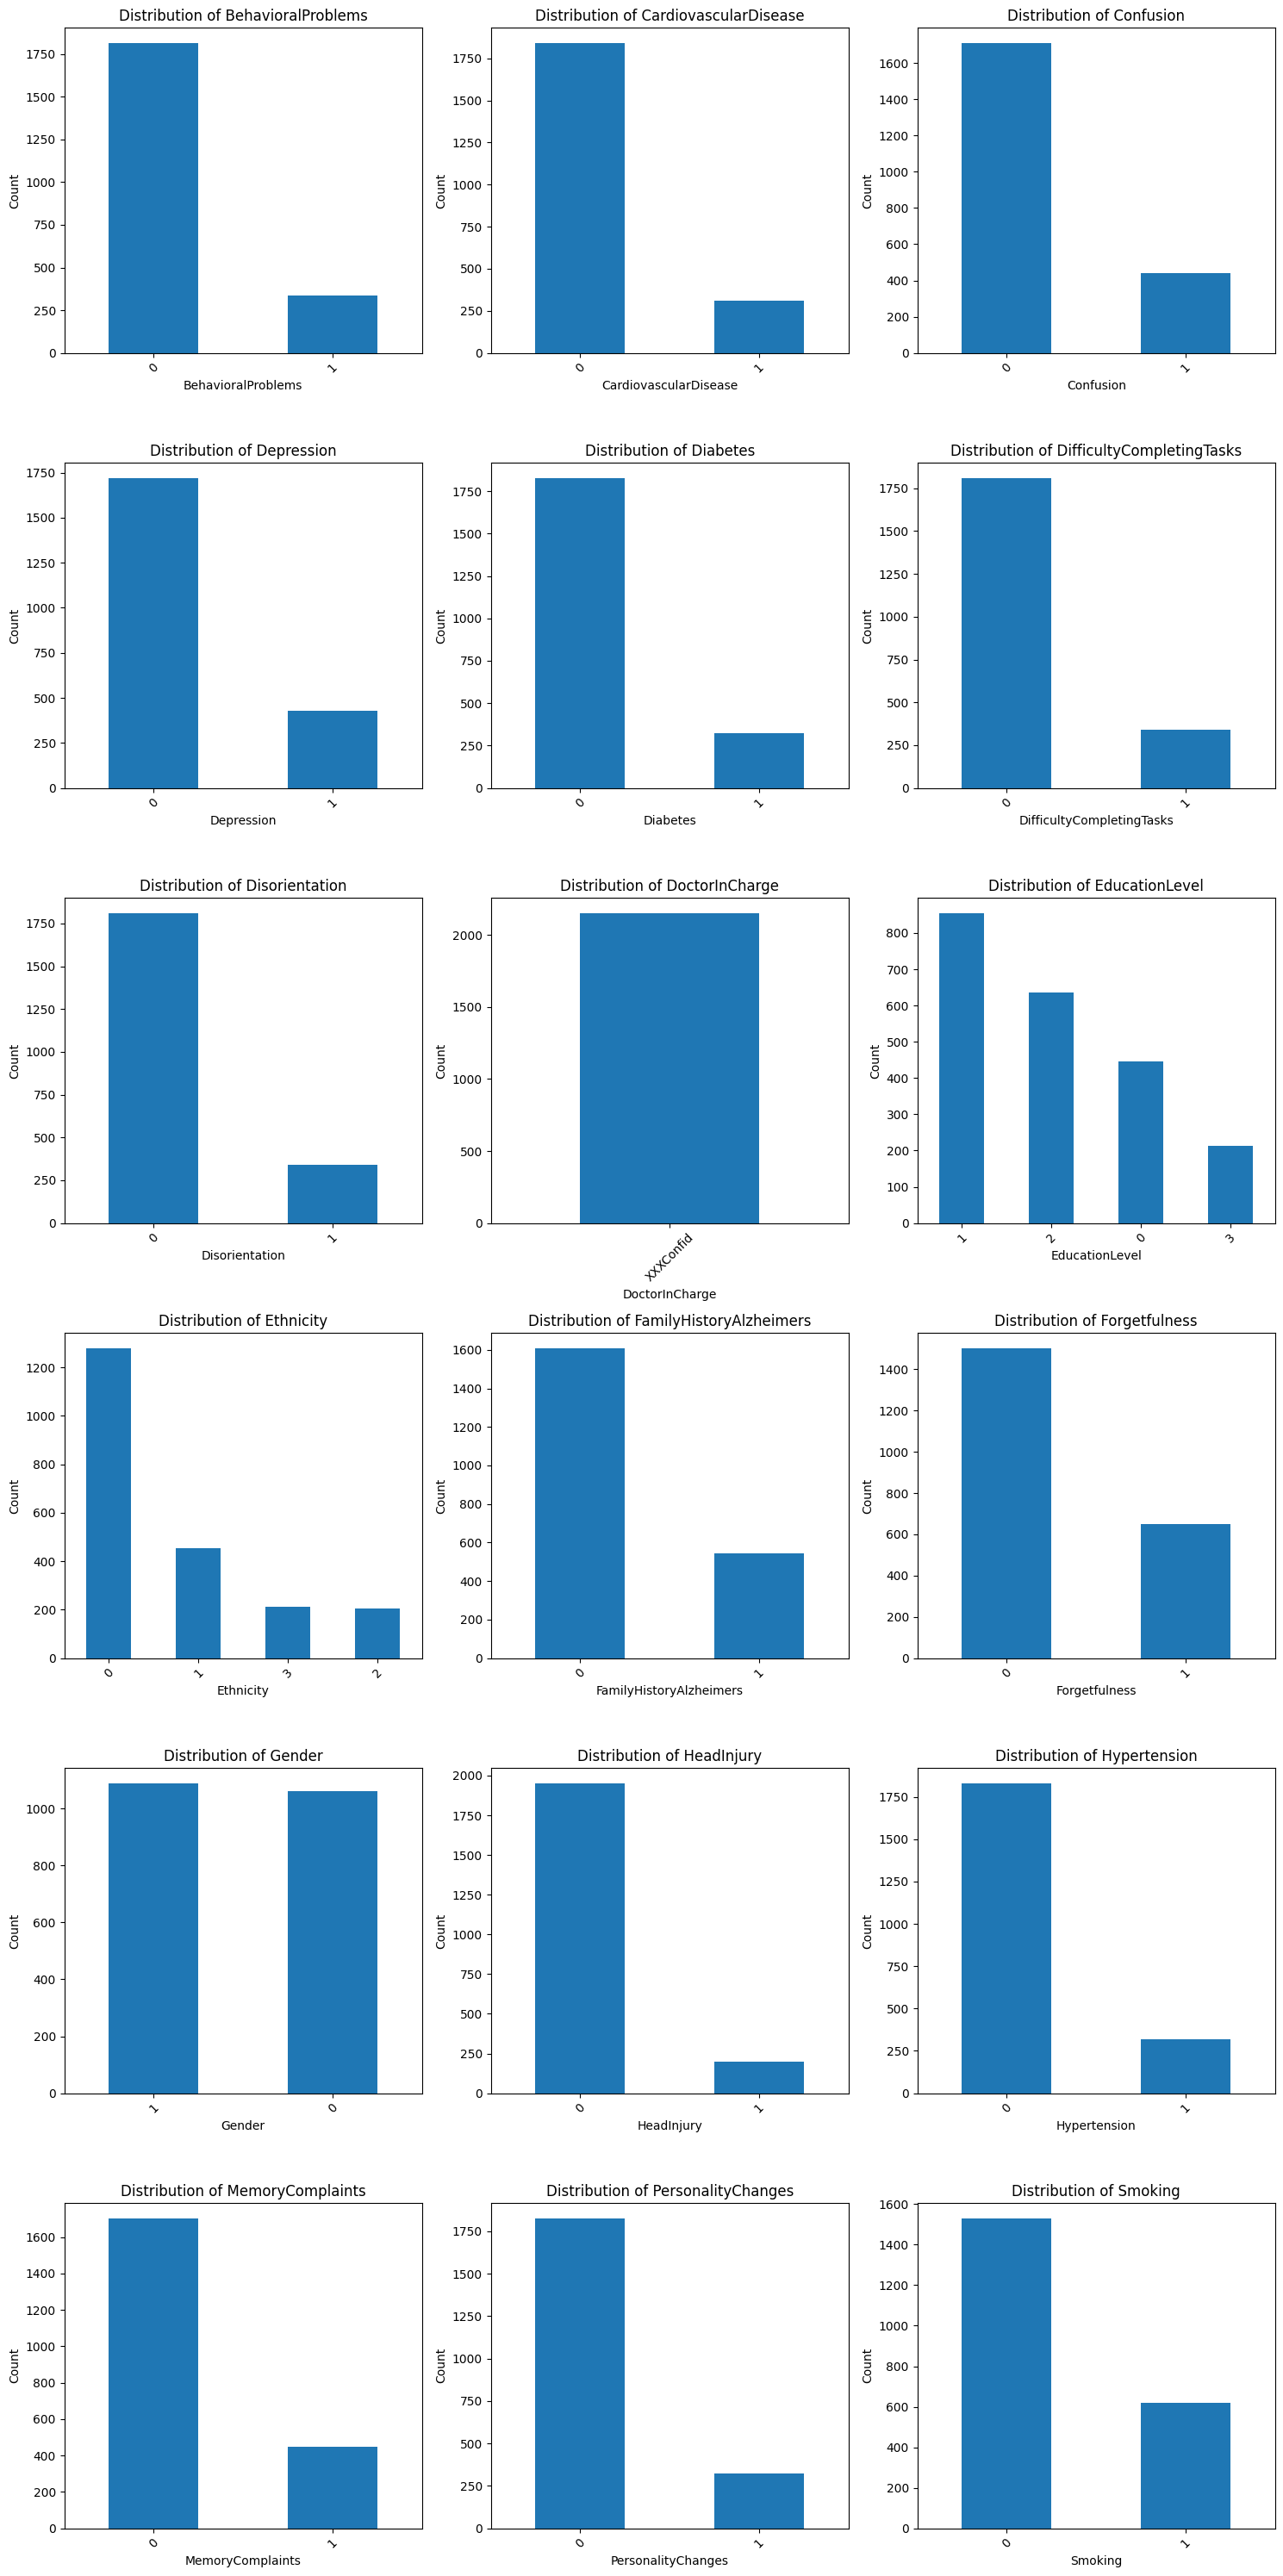

In [5]:
# Visualize categorical features
if len(categorical_columns) > 0:
    fig, axes = plt.subplots(int(np.ceil(len(categorical_columns)/3)), 3, figsize=(15, 5*int(np.ceil(len(categorical_columns)/3))))
    axes = axes.ravel() if len(categorical_columns) > 3 else [axes]

    for idx, col in enumerate(categorical_columns):
        if idx < len(axes):
            df[col].value_counts().plot(kind='bar', ax=axes[idx])
            axes[idx].set_title(f'Distribution of {col}')
            axes[idx].set_xlabel(col)
            axes[idx].set_ylabel('Count')
            axes[idx].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()


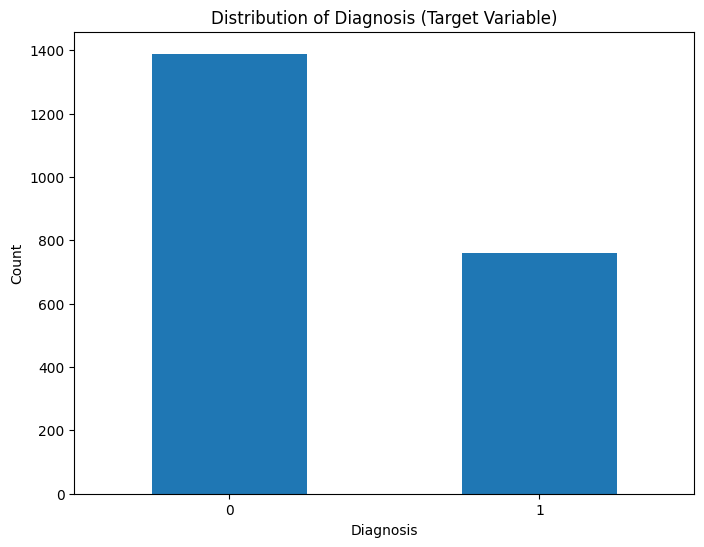

Class Distribution:
Diagnosis
0    1389
1     760
Name: count, dtype: int64
Class Balance Ratio: 1.83


In [6]:
#  2. TARGET VARIABLE ANALYSIS

# Check class balance
plt.figure(figsize=(8, 6))
df['Diagnosis'].value_counts().plot(kind='bar')
plt.title('Distribution of Diagnosis (Target Variable)')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

print("Class Distribution:")
print(df['Diagnosis'].value_counts())
print(f"Class Balance Ratio: {df['Diagnosis'].value_counts()[0] / df['Diagnosis'].value_counts()[1]:.2f}")

In [9]:
#  3. DEALING WITH MISSING VALUES

# Handle missing values for numerical columns
if missing_values.sum() > 0:
    # For numerical columns, use median imputation
    num_imputer = SimpleImputer(strategy='median')
    df[numerical_columns] = num_imputer.fit_transform(df[numerical_columns])

    # For categorical columns, use mode imputation
    if len(categorical_columns) > 0:
        cat_imputer = SimpleImputer(strategy='most_frequent')
        df[categorical_columns] = cat_imputer.fit_transform(df[categorical_columns])

print("Missing values after imputation:")
print(df.isnull().sum().sum())

Missing values after imputation:
0


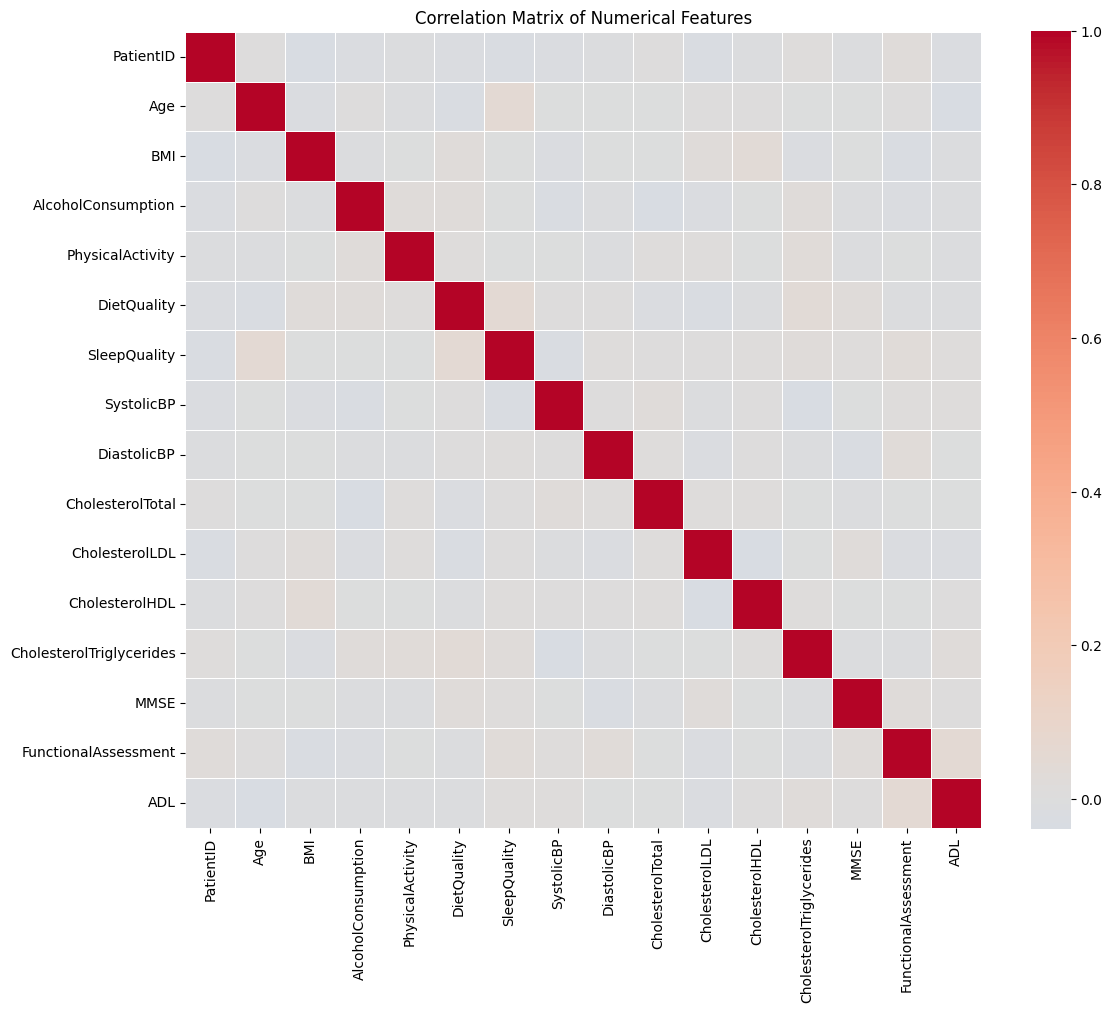

In [10]:
#  4. CORRELATION ANALYSIS

# Create correlation matrix for numerical features
plt.figure(figsize=(12, 10))
correlation_matrix = df[numerical_columns].corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0,
            square=True, linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

In [11]:
# Find features highly correlated with target (if target is numerical)
if 'Diagnosis' in df.columns:
    # Convert target to numerical if it's categorical
    if df['Diagnosis'].dtype == 'object':
        le = LabelEncoder()
        df['Diagnosis_encoded'] = le.fit_transform(df['Diagnosis'])
        target_corr = df[numerical_columns + ['Diagnosis_encoded']].corr()['Diagnosis_encoded'].sort_values(ascending=False)
    else:
        target_corr = df[numerical_columns + ['Diagnosis']].corr()['Diagnosis'].sort_values(ascending=False)

    print("Features most correlated with target:")
    print(target_corr.head(10))

Features most correlated with target:
Diagnosis                   1.000000
CholesterolHDL              0.042584
PatientID                   0.041019
BMI                         0.026343
CholesterolTriglycerides    0.022672
DietQuality                 0.008506
CholesterolTotal            0.006394
PhysicalActivity            0.005945
DiastolicBP                 0.005293
Age                        -0.005488
Name: Diagnosis, dtype: float64


Removed 1895 outliers


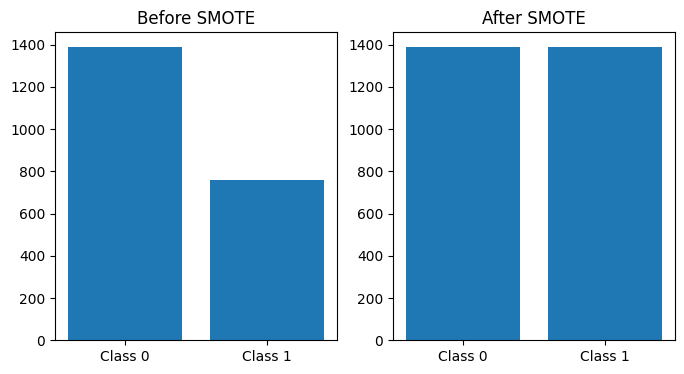

Training set size: (1719, 34)
Test set size: (430, 34)


In [12]:
#  5. DATA PREPROCESSING

# Encode categorical variables
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col + '_encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le

# Prepare features and target
# Use encoded categorical columns and numerical columns
feature_cols = numerical_columns + [col + '_encoded' for col in categorical_columns]
X = df[feature_cols]
y = df['Diagnosis_encoded'] if 'Diagnosis_encoded' in df.columns else df['Diagnosis']

# حذف داده های پرت با IQR
Q1 = np.percentile(X, 25, axis=0)
Q3 = np.percentile(X, 75, axis=0)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outlier_mask = ((X < lower_bound) | (X > upper_bound)).any(axis=1)
X_clean = X[~outlier_mask]
y_clean = y[~outlier_mask]

print(f"Removed {sum(outlier_mask)} outliers")


from imblearn.over_sampling import SMOTE

# Balance the data
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

#  split the balanced data
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42
)

# Simple plot
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.bar(['Class 0', 'Class 1'], [sum(y == 0), sum(y == 1)])
plt.title('Before SMOTE')
plt.subplot(1, 2, 2)
plt.bar(['Class 0', 'Class 1'], [sum(y_balanced == 0), sum(y_balanced == 1)])
plt.title('After SMOTE')
plt.show()

# Split data BEFORE normalization/standardization
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

In [13]:
#  6. NORMALIZATION AND STANDARDIZATION

# Define columns that need scaling (based on the notebook reference)
scale_columns = ['Age', 'BMI', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality',
                 'SleepQuality', 'SystolicBP', 'DiastolicBP', 'CholesterolTotal',
                 'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides',
                 'MMSE', 'FunctionalAssessment', 'ADL']

# Filter columns that actually exist in our dataset
scale_columns = [col for col in scale_columns if col in X_train.columns]

# Create copies for both normalization and standardization
X_train_normalized = X_train.copy()
X_test_normalized = X_test.copy()
X_train_standardized = X_train.copy()
X_test_standardized = X_test.copy()

# Normalize the columns (Min-Max Scaling)
min_max_scaler = MinMaxScaler()
X_train_normalized[scale_columns] = min_max_scaler.fit_transform(X_train[scale_columns])
X_test_normalized[scale_columns] = min_max_scaler.transform(X_test[scale_columns])

# Standardize the columns (Z-score normalization)
standard_scaler = StandardScaler()
X_train_standardized[scale_columns] = standard_scaler.fit_transform(X_train[scale_columns])
X_test_standardized[scale_columns] = standard_scaler.transform(X_test[scale_columns])

print(f"Scaled {len(scale_columns)} columns: {scale_columns}")

Scaled 15 columns: ['Age', 'BMI', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality', 'SystolicBP', 'DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment', 'ADL']


1. Mutual Information Scores (Top 10):
FunctionalAssessment          0.086064
ADL                           0.077301
MMSE                          0.067915
MemoryComplaints_encoded      0.031435
Gender_encoded                0.016643
PatientID                     0.013719
BehavioralProblems_encoded    0.012573
AlcoholConsumption            0.011914
CholesterolHDL                0.009035
CholesterolTotal              0.008191
dtype: float64
2. Chi-Square Scores (Top 10):
PatientID                        329.330417
MemoryComplaints_encoded         142.269386
BehavioralProblems_encoded        65.326114
FunctionalAssessment              37.385703
ADL                               34.277787
MMSE                              16.045227
CardiovascularDisease_encoded      2.844915
PersonalityChanges_encoded         2.275388
Diabetes_encoded                   1.670498
EducationLevel_encoded             1.553112
dtype: float64
3. ANOVA F-Scores (Top 10):
FunctionalAssessment             257.31876

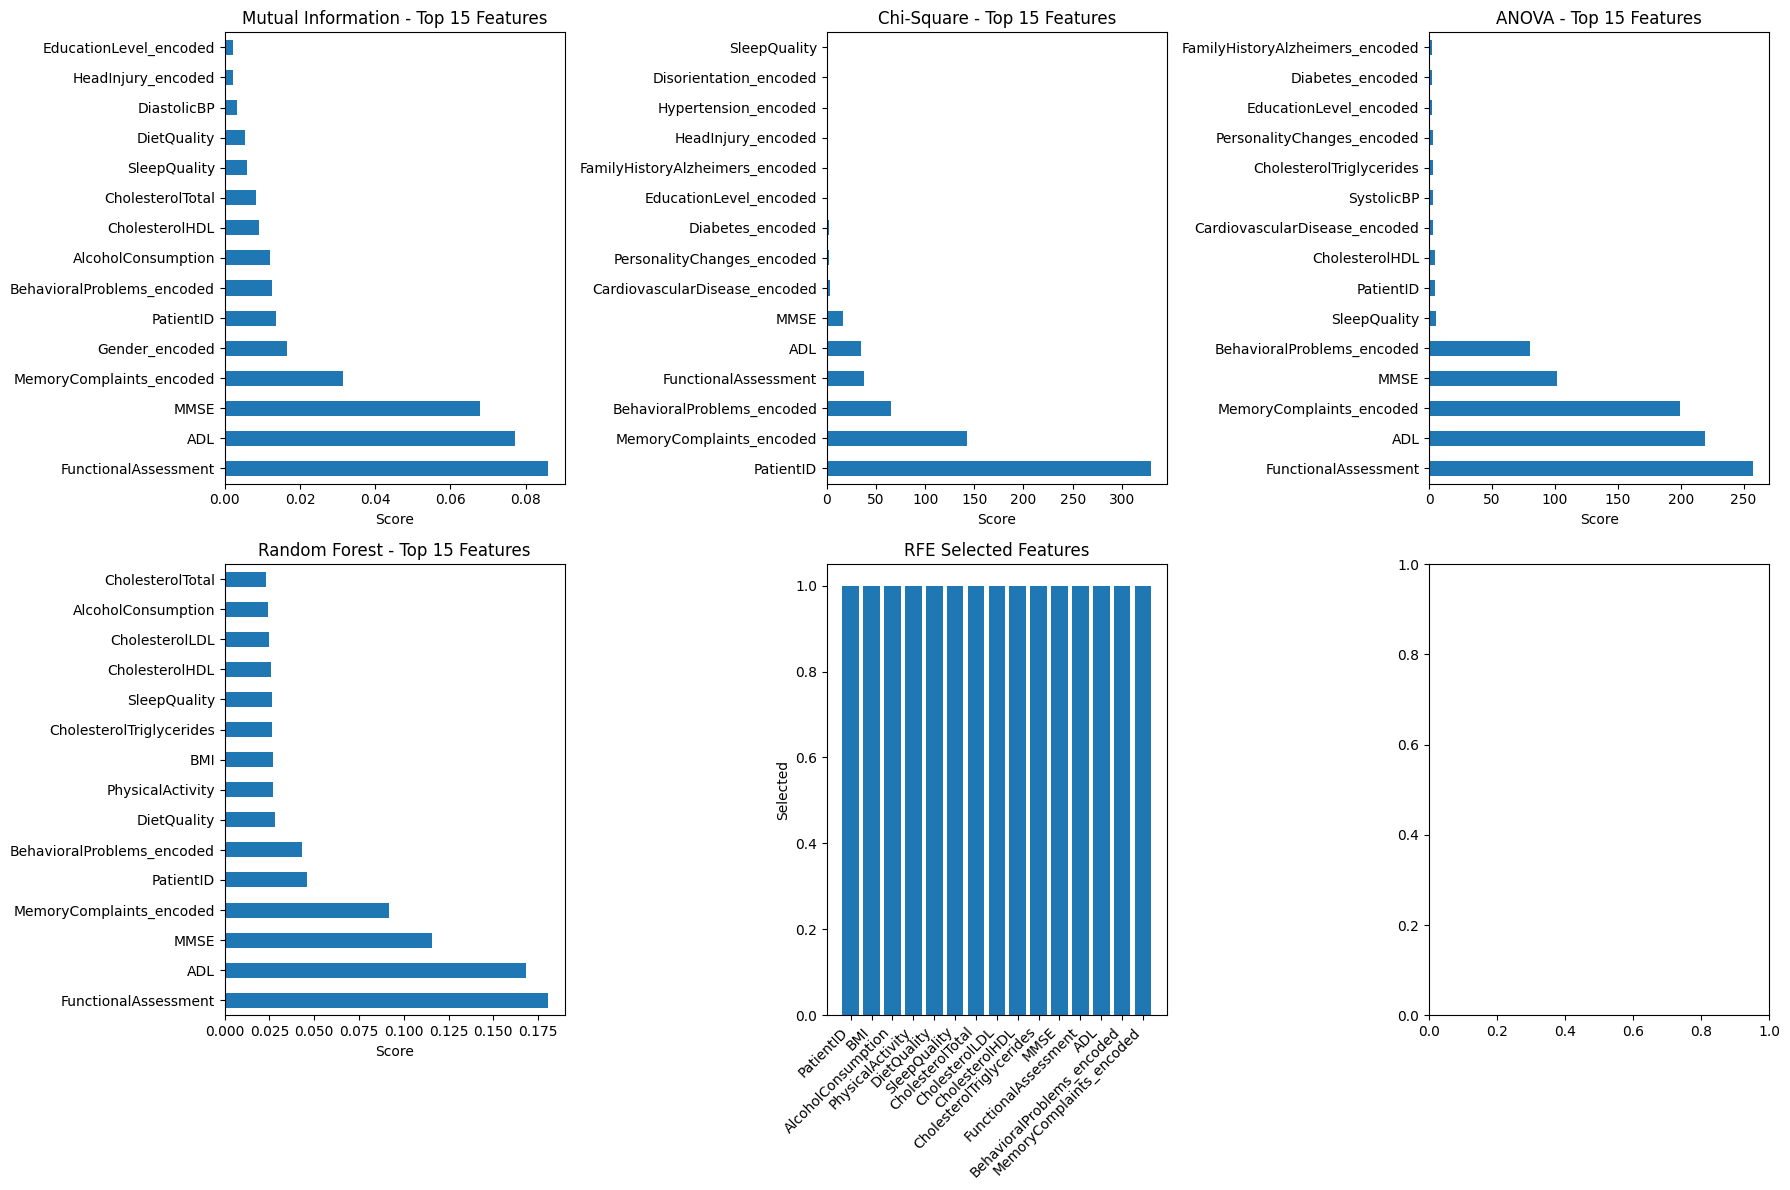

Features selected by at least 3 methods (13):
['FunctionalAssessment', 'ADL', 'MMSE', 'MemoryComplaints_encoded', 'PatientID', 'BehavioralProblems_encoded', 'AlcoholConsumption', 'CholesterolHDL', 'CholesterolTotal', 'SleepQuality', 'DietQuality', 'EducationLevel_encoded', 'CholesterolTriglycerides']
Final selected features using Random Forest importance:
['FunctionalAssessment', 'ADL', 'MMSE', 'MemoryComplaints_encoded', 'PatientID', 'BehavioralProblems_encoded', 'DietQuality', 'PhysicalActivity', 'BMI', 'CholesterolTriglycerides', 'SleepQuality', 'CholesterolHDL', 'CholesterolLDL', 'AlcoholConsumption', 'CholesterolTotal']


In [14]:
# ================== 7. FEATURE SELECTION ==================

# We'll use standardized data for feature selection
feature_selection_results = {}

# 1. Mutual Information
mi_scores = mutual_info_classif(X_train_standardized, y_train)
mi_scores = pd.Series(mi_scores, index=X_train.columns).sort_values(ascending=False)
feature_selection_results['Mutual Information'] = mi_scores

print("1. Mutual Information Scores (Top 10):")
print(mi_scores.head(10))

# 2. Chi-Square Test (only for non-negative features)
# ,ensure all features are non-negative for chi2
X_train_positive = X_train_normalized  # Use normalized data (0-1 range)
chi2_scores, chi2_pvalues = chi2(X_train_positive, y_train)
chi2_scores = pd.Series(chi2_scores, index=X_train.columns).sort_values(ascending=False)
feature_selection_results['Chi-Square'] = chi2_scores

print("2. Chi-Square Scores (Top 10):")
print(chi2_scores.head(10))

# 3. ANOVA F-value
f_scores, f_pvalues = f_classif(X_train_standardized, y_train)
f_scores = pd.Series(f_scores, index=X_train.columns).sort_values(ascending=False)
feature_selection_results['ANOVA'] = f_scores

print("3. ANOVA F-Scores (Top 10):")
print(f_scores.head(10))

# 4. Recursive Feature Elimination (RFE)
rf_for_rfe = RandomForestClassifier(n_estimators=100, random_state=42)
rfe = RFE(rf_for_rfe, n_features_to_select=15)
rfe.fit(X_train_standardized, y_train)
rfe_ranking = pd.Series(rfe.ranking_, index=X_train.columns).sort_values()
rfe_selected = X_train.columns[rfe.support_].tolist()

print(f"4. RFE Selected Features ({len(rfe_selected)}):")
print(rfe_selected)

# 5. Random Forest Feature Importance
rf_for_importance = RandomForestClassifier(n_estimators=100, random_state=42)
rf_for_importance.fit(X_train_standardized, y_train)
rf_importance = pd.Series(rf_for_importance.feature_importances_,
                         index=X_train.columns).sort_values(ascending=False)
feature_selection_results['Random Forest'] = rf_importance

print("5. Random Forest Feature Importance (Top 10):")
print(rf_importance.head(10))

# Visualize feature selection results
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

methods = ['Mutual Information', 'Chi-Square', 'ANOVA', 'Random Forest']
for idx, method in enumerate(methods):
    if idx < len(axes):
        feature_selection_results[method].head(15).plot(kind='barh', ax=axes[idx])
        axes[idx].set_title(f'{method} - Top 15 Features')
        axes[idx].set_xlabel('Score')

# RFE visualization
axes[4].bar(range(len(rfe_selected[:15])), [1]*len(rfe_selected[:15]))
axes[4].set_xticks(range(len(rfe_selected[:15])))
axes[4].set_xticklabels(rfe_selected[:15], rotation=45, ha='right')
axes[4].set_title('RFE Selected Features')
axes[4].set_ylabel('Selected')

plt.tight_layout()
plt.show()

# Select best feature selection method based on consistency
#  using the method that produces the most consistent top features
top_n = 15

# Get top features from each method
top_features_dict = {
    'Mutual Information': mi_scores.head(top_n).index.tolist(),
    'Chi-Square': chi2_scores.head(top_n).index.tolist(),
    'ANOVA': f_scores.head(top_n).index.tolist(),
    'Random Forest': rf_importance.head(top_n).index.tolist(),
    'RFE': rfe_selected[:top_n]
}

# Find common features across methods
from collections import Counter
all_top_features = []
for features in top_features_dict.values():
    all_top_features.extend(features)

feature_counts = Counter(all_top_features)
common_features = [feature for feature, count in feature_counts.items() if count >= 3]

print(f"Features selected by at least 3 methods ({len(common_features)}):")
print(common_features)

# Use Random Forest importance as the final selection method (typically most reliable)
selected_features = rf_importance.head(15).index.tolist()
print(f"Final selected features using Random Forest importance:")
print(selected_features)

# Create datasets with selected features
X_train_selected = X_train_standardized[selected_features]
X_test_selected = X_test_standardized[selected_features]


In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Define optimized parameter grids
param_grids = {
    'Decision Tree': {
       'max_depth': [3, 5, 7, 10, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'criterion': ['gini', 'entropy']
    },
    'Random Forest': {
        'n_estimators': [50, 100],
        'max_depth': [None, 10],
        'min_samples_leaf': [1, 4],
    },
    'Naive Bayes': {
        'var_smoothing': [1e-9, 1e-8, 1e-7],
    },
    'SVM': {
        'C': [1, 10],
        'kernel': ['linear'],
        'gamma': ['scale'],   # Usually 'scale' suffices for most cases
    },
    'Logistic Regression': {
        'C': [0.1, 1, 10],
        'penalty': ['l2'],    # 'l2' is most common and works for solver='lbfgs'
        'solver': ['lbfgs']
    },
    'K-Nearest Neighbors': {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }
}

# Map model names to their scikit-learn classes
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

model_classes = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Naive Bayes': GaussianNB(),
    'SVM': SVC(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

best_estimators = {}
best_scores = {}

for name, model in model_classes.items():
    print(f"\nTraining {name}...")
    clf = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        cv=3,  # reduced number of folds for faster computation
        n_jobs=-1,
        scoring='accuracy',
        verbose=1
    )
    clf.fit(X_train, y_train)
    print(f"Best params for {name}: {clf.best_params_}")
    print(f"Best CV score: {clf.best_score_:.4f}")
    best_estimators[name] = clf.best_estimator_
    best_scores[name] = clf.best_score_



Training Decision Tree...
Fitting 3 folds for each of 90 candidates, totalling 270 fits
Best params for Decision Tree: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10}
Best CV score: 0.9471

Training Random Forest...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best params for Random Forest: {'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 100}
Best CV score: 0.9244

Training Naive Bayes...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best params for Naive Bayes: {'var_smoothing': 1e-07}
Best CV score: 0.8237

Training SVM...
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best params for SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Best CV score: 0.8278

Training Logistic Regression...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best params for Logistic Regression: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV score: 0.8208

Training K-Nearest Neighbors...
Fitting 3 

Model Evaluation:

Decision Tree:
  Accuracy: 0.956
  Precision: 0.956
  Recall: 0.956
  F1-Score: 0.956

Random Forest:
  Accuracy: 0.930
  Precision: 0.931
  Recall: 0.930
  F1-Score: 0.929

Naive Bayes:
  Accuracy: 0.812
  Precision: 0.809
  Recall: 0.812
  F1-Score: 0.809

SVM:
  Accuracy: 0.842
  Precision: 0.840
  Recall: 0.842
  F1-Score: 0.840

Logistic Regression:
  Accuracy: 0.826
  Precision: 0.823
  Recall: 0.826
  F1-Score: 0.824

K-Nearest Neighbors:
  Accuracy: 0.565
  Precision: 0.517
  Recall: 0.565
  F1-Score: 0.530

Comparison Table:
              Model  Accuracy  Precision  Recall  F1-Score
      Decision Tree     0.956      0.956   0.956     0.956
      Random Forest     0.930      0.931   0.930     0.929
                SVM     0.842      0.840   0.842     0.840
Logistic Regression     0.826      0.823   0.826     0.824
        Naive Bayes     0.812      0.809   0.812     0.809
K-Nearest Neighbors     0.565      0.517   0.565     0.530

🏆 Best Model: Decision Tree

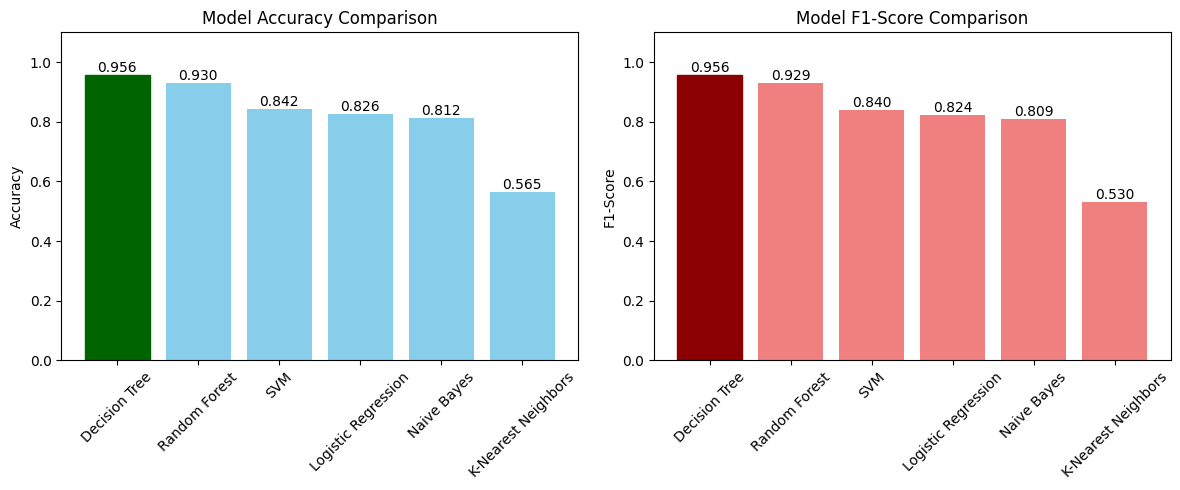

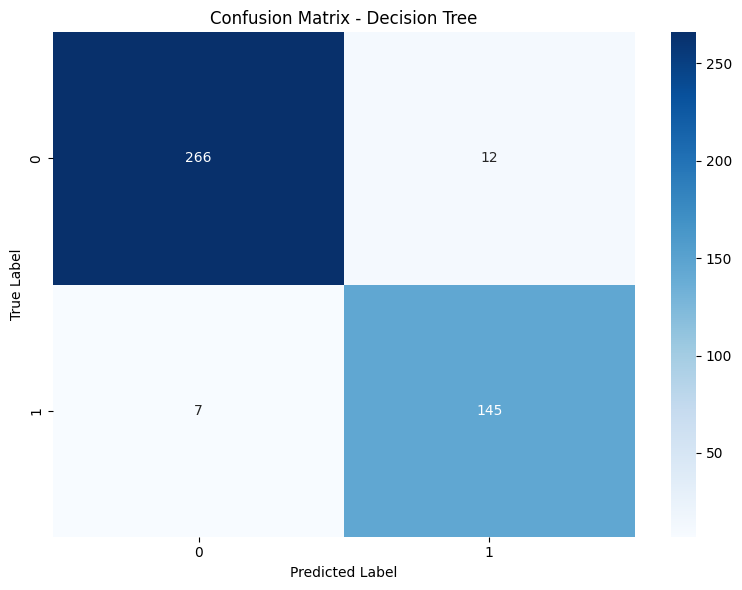

In [16]:
#  Simple Model Evaluation with Metrics


# Calculate metrics for all models
print("Model Evaluation:")
print("=" * 60)

results = []
for name, model in best_estimators.items():
    y_pred = model.predict(X_test)

    # Calculate main metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1
    })

    print(f"\n{name}:")
    print(f"  Accuracy: {acc:.3f}")
    print(f"  Precision: {prec:.3f}")
    print(f"  Recall: {rec:.3f}")
    print(f"  F1-Score: {f1:.3f}")

# Convert to DataFrame
df_results = pd.DataFrame(results)
df_results = df_results.sort_values('Accuracy', ascending=False)

print("\n" + "=" * 60)
print("Comparison Table:")
print(df_results.round(3).to_string(index=False))

# Find best model
best_model = df_results.iloc[0]['Model']
print(f"\n🏆 Best Model: {best_model}")

# Simple bar charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy chart
models = df_results['Model'].tolist()
accuracies = df_results['Accuracy'].tolist()

bars1 = ax1.bar(models, accuracies, color='skyblue')
bars1[0].set_color('darkgreen')  # Best model

for i, v in enumerate(accuracies):
    ax1.text(i, v + 0.01, f'{v:.3f}', ha='center')

ax1.set_ylabel('Accuracy')
ax1.set_title('Model Accuracy Comparison')
ax1.set_ylim(0, 1.1)
ax1.tick_params(axis='x', rotation=45)

# F1-Score chart
f1_scores = df_results['F1-Score'].tolist()

bars2 = ax2.bar(models, f1_scores, color='lightcoral')
bars2[0].set_color('darkred')  # Best model

for i, v in enumerate(f1_scores):
    ax2.text(i, v + 0.01, f'{v:.3f}', ha='center')

ax2.set_ylabel('F1-Score')
ax2.set_title('Model F1-Score Comparison')
ax2.set_ylim(0, 1.1)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Confusion matrix for best model
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(8, 6))
best_model_obj = best_estimators[best_model]
y_pred_best = best_model_obj.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f'Confusion Matrix - {best_model}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


In [17]:
# Analyze misclassified samples
misclassified = X_test[y_test != y_pred_best]
print(f"Number of misclassified samples: {len(misclassified)}")
print(f"Misclassification rate: {len(misclassified)/len(X_test):.2%}")


Number of misclassified samples: 19
Misclassification rate: 4.42%
